In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from tensorflow.keras.layers import Input, concatenate, LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, Dropout, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from skimage.transform import resize
import os
import csv
import PIL
import numpy as np
import random
import cv2
import imutils
import tensorflow.keras.backend as K
import tensorflow as tf

In [ ]:
HEIGHT = 240
WIDTH = 320
INIT_LR = 0.0001
EPOCHS = 15
TRAIN_PATH = "./data/nyu2_train.csv"
TEST_PATH = "./data/nyu2_test.csv"

In [ ]:
def downsampling_block(input_tensor, n_filters):
  x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(input_tensor)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)
  return x

def upsampling_block(input_tensor, n_filters, name, concat_with):
  x = UpSampling2D((2, 2), interpolation='bilinear', name=name)(input_tensor)
  x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convA")(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = concatenate([x, concat_with], axis=3)

  x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convB")(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convC")(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)
  return x

In [ ]:
def build(height, width, depth):
  # input
  i = Input(shape=(height, width, depth))

  # encoder
  conv1 = downsampling_block(i, 32)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = downsampling_block(pool1, 64)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = downsampling_block(pool2, 128)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = downsampling_block(pool3, 256)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

  # bottleneck
  conv5 = Conv2D(512, (3, 3), padding='same')(pool4)
  conv5 = LeakyReLU(alpha=0.2)(conv5)
  conv5 = Conv2D(512, (3, 3), padding='same')(conv5)
  conv5 = LeakyReLU(alpha=0.2)(conv5)

  # decoder
  conv6 = upsampling_block(conv5, 256, "up1", concat_with=conv4)
  conv7 = upsampling_block(conv6, 128, "up2", concat_with=conv3)
  conv8 = upsampling_block(conv7, 64, "up3", concat_with=conv2)
  conv9 = upsampling_block(conv8, 32, "up4", concat_with=conv1)

  # output
  o = Conv2D(filters=1, kernel_size=3, strides=(1,1), activation='sigmoid', padding='same', name='conv10')(conv9)

  model = Model(inputs=i, outputs=o)
  return model

In [ ]:
model = build(HEIGHT, WIDTH, 3)

In [ ]:
model.summary()
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='./model.png')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 240, 320, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_22 (LeakyReLU)      (None, 240, 320, 32) 0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 240, 320, 32) 128         leaky_re_lu_22[0][0]             
____________________________________________________________________________________________

In [ ]:
!git clone https://gitlab.com/siddinc/new_depth.git ./data

Cloning into './data'...
remote: Enumerating objects: 65371, done.
remote: Counting objects: 100% (65371/65371), done.
remote: Compressing objects: 100% (65371/65371), done.
remote: Total 65371 (delta 2), reused 65366 (delta 0), pack-reused 0
Receiving objects: 100% (65371/65371), 2.79 GiB | 34.37 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (65418/65418), done.


In [ ]:
# loading the dataset

def read_csv(csv_file_path):
  with open(csv_file_path, 'r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    return [('./' + row[0], './' + row[1]) for row in csv_reader if len(row) > 0]

def train_val_split(train_paths, val_size):
  random.shuffle(train_paths)
  len_train_paths = len(train_paths)
  i = int(len_train_paths*(1.0 - val_size))
  train = train_paths[0:i]
  val = train_paths[i:len(train_paths)]
  return train, val

def load_train_paths(train_path):
  train_paths = read_csv(train_path)
  labels = {img_path: dm_path for img_path, dm_path in train_paths}
  x_paths = [img_path for img_path, dm in train_paths]
  x_train_paths, x_val_paths = train_val_split(x_paths, 0.3)

  partition = {
    'train': x_train_paths,
    'validation': x_val_paths
  }
  return partition, labels

In [ ]:
# preprocessing the dataset

def normalize_img(img):
    norm_img = (img - img.min()) / (img.max() - img.min())
    return norm_img

def preprocess_image(img_path, horizontal_flip=False):
  image = cv2.imread(img_path)
  image = imutils.resize(image, height=HEIGHT)
  # image = image[:, 21:149].astype("float")
  image = image.astype("float")
  image = normalize_img(image)

  if horizontal_flip:
    image = cv2.flip(image, 1)
  return image

def preprocess_depth_map(depth_map_path, horizontal_flip=False):
  depth_map = cv2.imread(depth_map_path)
  depth_map = cv2.cvtColor(depth_map, cv2.COLOR_BGR2GRAY)
  depth_map = imutils.resize(depth_map, height=HEIGHT)
  # depth_map = depth_map[:, 21:149].astype("float")
  depth_map = depth_map.astype("float")
  depth_map = normalize_img(depth_map)

  if horizontal_flip:
    depth_map = cv2.flip(depth_map, 1)

  depth_map = np.reshape(depth_map, (depth_map.shape[0], depth_map.shape[1], 1))
  return depth_map

In [ ]:
# data generator

from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
  def __init__(self, list_IDs, labels, batch_size=16, dim=(128,128), n_channels=3, shuffle=True, pred=False):
    self.dim = dim
    self.batch_size = batch_size
    self.labels = labels
    self.list_IDs = list_IDs
    self.n_channels = n_channels
    self.shuffle = shuffle
    self.pred = pred
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    list_IDs_temp = [self.list_IDs[k] for k in indexes]
    if self.pred:
      X = self.__data_generation(list_IDs_temp)
      return X
    X, y = self.__data_generation(list_IDs_temp)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_temp):
    X = np.empty((self.batch_size, self.dim[0], self.dim[1],self.n_channels))

    if not self.pred:
      y = np.empty((self.batch_size, self.dim[0], self.dim[1], 1))

      for i, ID in enumerate(list_IDs_temp):
        res = random.choice([True, False])
        X[i,] = preprocess_image(ID, res)
        y[i,] = preprocess_depth_map(self.labels[ID], res)
      return X, y
    else:
      for i, ID in enumerate(list_IDs_temp):
        res = random.choice([True, False])
        X[i,] = preprocess_image(ID, res)
      return X

In [ ]:
partition, labels = load_train_paths(TRAIN_PATH)

In [ ]:
print(len(partition['train']), len(partition['validation']))

22437 9617


In [ ]:
training_generator = DataGenerator(list_IDs=partition['train'], labels=labels, batch_size=16, dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)
validation_generator = DataGenerator(list_IDs=partition['validation'], labels=labels, batch_size=16, dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)

In [ ]:
def poly_decay(epoch):
  maxEpochs = EPOCHS
  baseLR = INIT_LR
  power = 1.0
  alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
  return alpha

opt = Adam(lr=INIT_LR, amsgrad=True)
callbacks = [LearningRateScheduler(poly_decay)]

# custom loss
def depth_loss(y_true, y_pred):
  w1, w2, w3 = 1.0, 1.0, 0.1

  l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)

  dy_true, dx_true = tf.image.image_gradients(y_true)
  dy_pred, dx_pred = tf.image.image_gradients(y_pred)
  l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

  l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 0.5, 0, 1)

  return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))

#custom soft accuracy
def depth_acc(y_true, y_pred):
  return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

In [ ]:
model.compile(optimizer=opt, loss=depth_loss, metrics=[depth_acc])

In [ ]:
r = model.fit(training_generator, validation_data=validation_generator, epochs=15, callbacks=callbacks)

Epoch 1/15
1402/1402 [==============================] - 523s 373ms/step - loss: 0.1135 - depth_acc: 0.8644 - val_loss: 0.1090 - val_depth_acc: 0.8711 - lr: 1.0000e-04
Epoch 2/15
1402/1402 [==============================] - 526s 375ms/step - loss: 0.1062 - depth_acc: 0.8754 - val_loss: 0.1025 - val_depth_acc: 0.8808 - lr: 9.3333e-05
Epoch 3/15
1402/1402 [==============================] - 520s 371ms/step - loss: 0.0998 - depth_acc: 0.8853 - val_loss: 0.0987 - val_depth_acc: 0.8905 - lr: 8.6667e-05
Epoch 4/15
1402/1402 [==============================] - 523s 373ms/step - loss: 0.0947 - depth_acc: 0.8925 - val_loss: 0.0934 - val_depth_acc: 0.8958 - lr: 8.0000e-05
Epoch 5/15
1402/1402 [==============================] - 522s 372ms/step - loss: 0.0903 - depth_acc: 0.8988 - val_loss: 0.0892 - val_depth_acc: 0.9019 - lr: 7.3333e-05
Epoch 6/15
1402/1402 [==============================] - 527s 376ms/step - loss: 0.0867 - depth_acc: 0.9037 - val_loss: 0.0857 - val_depth_acc: 0.9061 - lr: 6.6667e-0

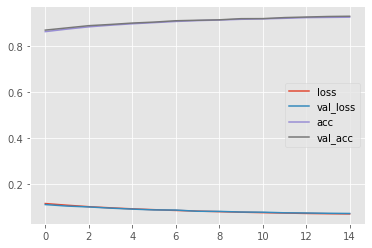

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# e = np.linspace(1, EPOCHS, num=EPOCHS)

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')

plt.plot(r.history['depth_acc'], label='acc')
plt.plot(r.history['val_depth_acc'], label='val_acc')

plt.legend()
plt.show()

In [ ]:
img_dm_pairs = read_csv('./data/nyu2_test.csv')
labels = {i: j for i,j in img_dm_pairs}
test_paths = [i for i,j in img_dm_pairs]
print(len(test_paths))
partition = {'test': test_paths}

654


In [ ]:
x_test = np.empty((len(test_paths), HEIGHT, WIDTH, 3))
y_test = np.empty((len(test_paths), HEIGHT, WIDTH, 1))

for i, ID in enumerate(partition['test'][:]):
  x_test[i, ] = preprocess_image(ID, horizontal_flip=False)
  y_test[i, ] = preprocess_depth_map(labels[ID], horizontal_flip=False)

In [ ]:
print(model.evaluate(x_test, y_test))

21/21 [==============================] - 4s 183ms/step - loss: 0.1880 - depth_acc: 0.7682
[0.18799662590026855, 0.7682366371154785]


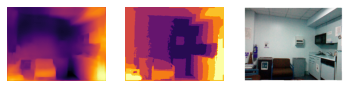

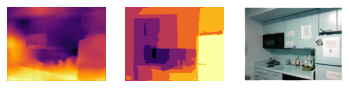

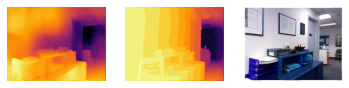

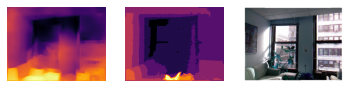

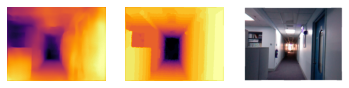

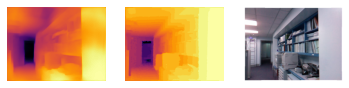

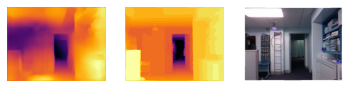

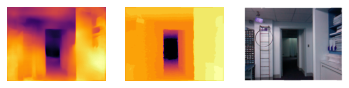

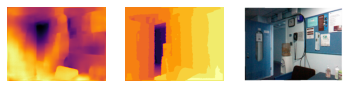

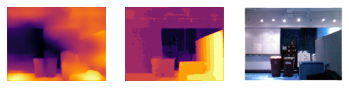

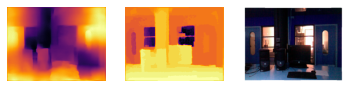

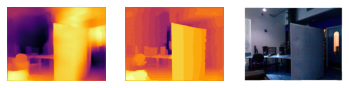

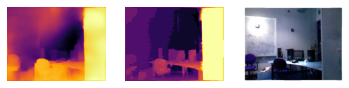

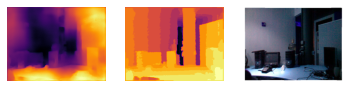

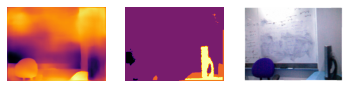

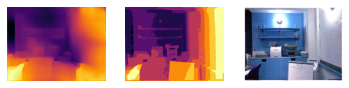

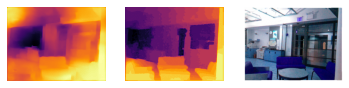

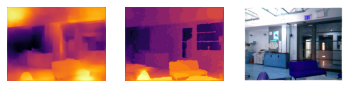

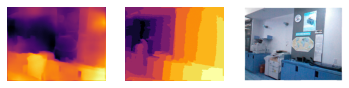

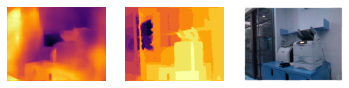

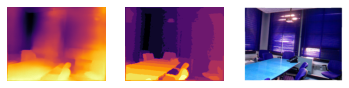

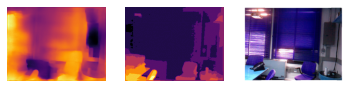

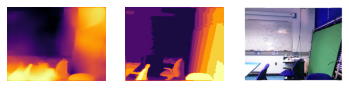

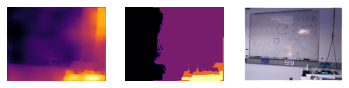

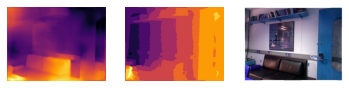

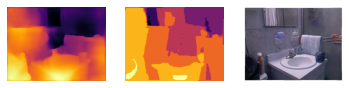

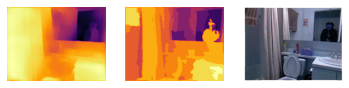

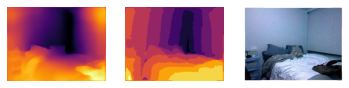

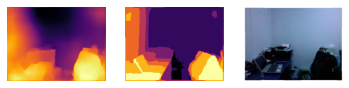

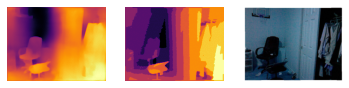

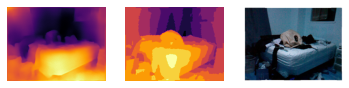

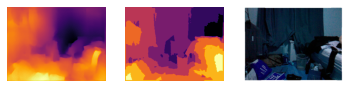

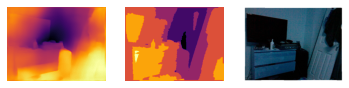

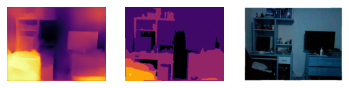

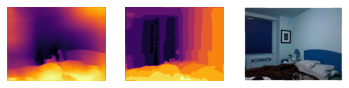

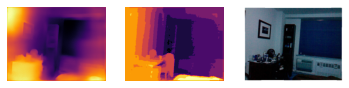

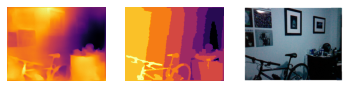

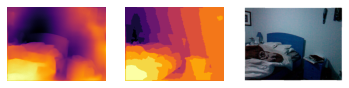

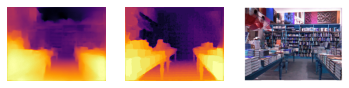

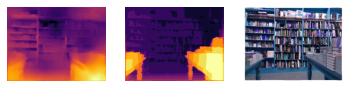

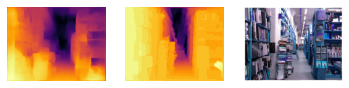

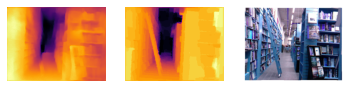

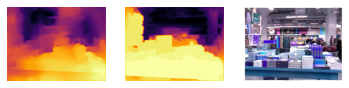

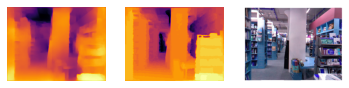

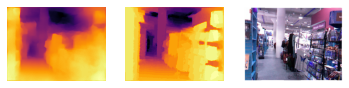

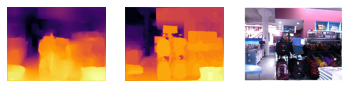

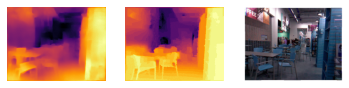

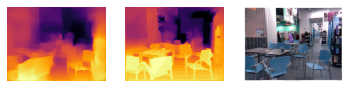

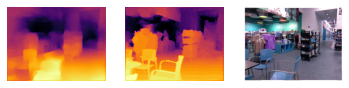

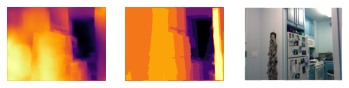

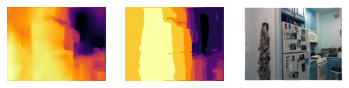

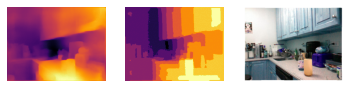

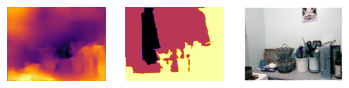

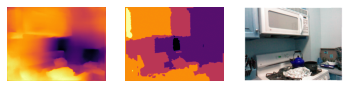

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

preds = model.predict(x_test)

for i in range(len(test_paths)-600):
  path = partition['test'][i]
  label_path = labels[path]
  pred = preds[i]
  pred = np.squeeze(pred, axis=-1)

  plt.subplot(1,3,1)
  plt.axis("off")
  plt.imshow(pred, cmap=plt.get_cmap('inferno_r'))

  plt.subplot(1,3,2)
  plt.axis("off")
  img = preprocess_depth_map(label_path, horizontal_flip=False)
  img = np.squeeze(img, axis=-1)
  plt.imshow(img, cmap=plt.get_cmap('inferno_r'))

  plt.subplot(1,3,3)
  plt.axis("off")
  img1 = preprocess_image(path, horizontal_flip=False)
  plt.imshow(img1)

  plt.show()